In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

SR = 44100
blocksize = 88200
overlap = 44100

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 1.018596887588501
(1506, 1, 88200)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 77ms/step - loss: 1454.5876
(1, 88200)


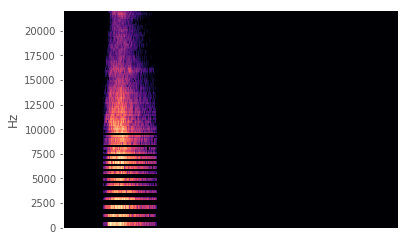

(1506, 128, 345)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
frames = mfccs

In [19]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(1506, 128, 345, 1)

In [20]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 345, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 337, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 19, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                77856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

1023/1023 [==============================] - 33s 32ms/step - loss: 0.4491 - acc: 0.7977 - mean_absolute_error: 0.2945 - val_loss: 0.6952 - val_acc: 0.6685 - val_mean_absolute_error: 0.4091
Epoch 36/100
1023/1023 [==============================] - 33s 33ms/step - loss: 0.4332 - acc: 0.7986 - mean_absolute_error: 0.3033 - val_loss: 0.6238 - val_acc: 0.7072 - val_mean_absolute_error: 0.3573
Epoch 37/100
1023/1023 [==============================] - 33s 33ms/step - loss: 0.4111 - acc: 0.8162 - mean_absolute_error: 0.2912 - val_loss: 0.6638 - val_acc: 0.7072 - val_mean_absolute_error: 0.3490
Epoch 38/100
1023/1023 [==============================] - 32s 31ms/step - loss: 0.3943 - acc: 0.8201 - mean_absolute_error: 0.2753 - val_loss: 0.6767 - val_acc: 0.7127 - val_mean_absolute_error: 0.3426
Epoch 39/100
1023/1023 [==============================] - 32s 31ms/step - loss: 0.3984 - acc: 0.8221 - mean_absolute_error: 0.2761 - val_loss: 0.6398 - val_acc: 0.6906 - val_mean_absolute_error: 0.3535
Epo

1023/1023 [==============================] - 32s 31ms/step - loss: 0.2384 - acc: 0.8954 - mean_absolute_error: 0.1712 - val_loss: 0.8268 - val_acc: 0.7459 - val_mean_absolute_error: 0.3158
Epoch 80/100
1023/1023 [==============================] - 32s 32ms/step - loss: 0.2407 - acc: 0.8886 - mean_absolute_error: 0.1723 - val_loss: 0.8841 - val_acc: 0.7238 - val_mean_absolute_error: 0.3039
Epoch 81/100
1023/1023 [==============================] - 33s 32ms/step - loss: 0.2473 - acc: 0.8856 - mean_absolute_error: 0.1716 - val_loss: 0.7811 - val_acc: 0.7293 - val_mean_absolute_error: 0.2938
Epoch 82/100
1023/1023 [==============================] - 35s 34ms/step - loss: 0.2303 - acc: 0.8925 - mean_absolute_error: 0.1648 - val_loss: 0.8377 - val_acc: 0.7127 - val_mean_absolute_error: 0.2925
Epoch 83/100
1023/1023 [==============================] - 34s 33ms/step - loss: 0.2247 - acc: 0.9032 - mean_absolute_error: 0.1605 - val_loss: 0.7565 - val_acc: 0.7459 - val_mean_absolute_error: 0.3022
Epo

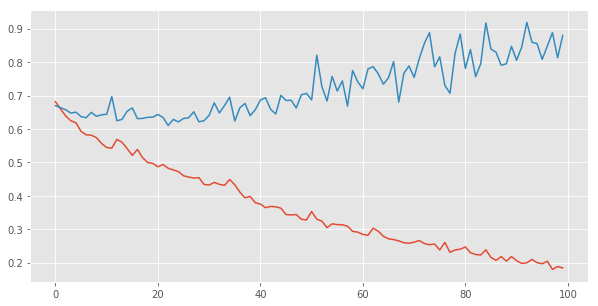

In [21]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

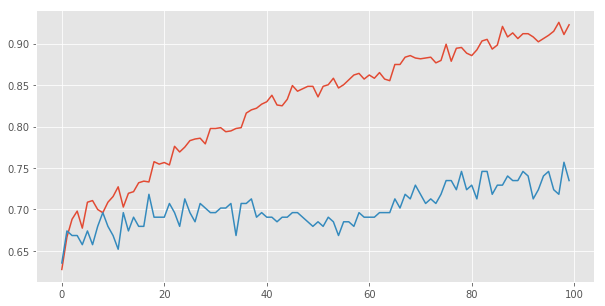

In [22]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.7748344370860927
Confusion matrix, without normalization
[[ 80  46]
 [ 22 154]]


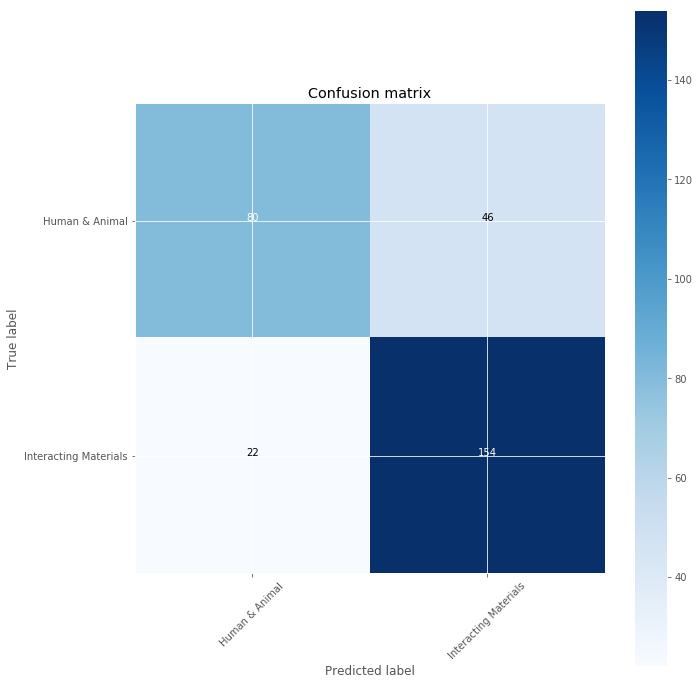

In [23]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [24]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [25]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [26]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 345, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 343, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 20, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               409728    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

Epoch 31/200
383/383 [==============================] - 4s 11ms/step - loss: 2.7676 - acc: 0.1018 - mean_absolute_error: 0.0977 - val_loss: 2.6913 - val_acc: 0.1765 - val_mean_absolute_error: 0.0969
Epoch 32/200
383/383 [==============================] - 4s 11ms/step - loss: 2.8014 - acc: 0.1070 - mean_absolute_error: 0.0971 - val_loss: 2.6912 - val_acc: 0.1471 - val_mean_absolute_error: 0.0964
Epoch 33/200
383/383 [==============================] - 4s 11ms/step - loss: 2.7768 - acc: 0.0888 - mean_absolute_error: 0.0976 - val_loss: 2.7887 - val_acc: 0.0735 - val_mean_absolute_error: 0.0983
Epoch 34/200
383/383 [==============================] - 4s 11ms/step - loss: 2.8255 - acc: 0.1044 - mean_absolute_error: 0.0982 - val_loss: 2.7583 - val_acc: 0.1176 - val_mean_absolute_error: 0.0980
Epoch 35/200
383/383 [==============================] - 4s 10ms/step - loss: 2.7549 - acc: 0.1384 - mean_absolute_error: 0.0978 - val_loss: 2.7353 - val_acc: 0.1618 - val_mean_absolute_error: 0.0970
Epoch

383/383 [==============================] - 4s 11ms/step - loss: 2.4691 - acc: 0.1802 - mean_absolute_error: 0.0914 - val_loss: 2.3831 - val_acc: 0.2059 - val_mean_absolute_error: 0.0912
Epoch 73/200
383/383 [==============================] - 4s 11ms/step - loss: 2.5498 - acc: 0.1671 - mean_absolute_error: 0.0934 - val_loss: 2.5033 - val_acc: 0.2059 - val_mean_absolute_error: 0.0948
Epoch 74/200
383/383 [==============================] - 4s 11ms/step - loss: 2.5240 - acc: 0.1488 - mean_absolute_error: 0.0939 - val_loss: 2.5652 - val_acc: 0.2353 - val_mean_absolute_error: 0.0941
Epoch 75/200
383/383 [==============================] - 4s 11ms/step - loss: 2.4915 - acc: 0.1410 - mean_absolute_error: 0.0934 - val_loss: 2.4304 - val_acc: 0.2500 - val_mean_absolute_error: 0.0927
Epoch 76/200
383/383 [==============================] - 4s 10ms/step - loss: 2.4651 - acc: 0.2037 - mean_absolute_error: 0.0922 - val_loss: 2.4122 - val_acc: 0.2059 - val_mean_absolute_error: 0.0916
Epoch 77/200
383/3

383/383 [==============================] - 4s 11ms/step - loss: 1.8375 - acc: 0.3342 - mean_absolute_error: 0.0776 - val_loss: 2.2164 - val_acc: 0.3529 - val_mean_absolute_error: 0.0800
Epoch 114/200
383/383 [==============================] - 4s 11ms/step - loss: 1.7574 - acc: 0.3890 - mean_absolute_error: 0.0758 - val_loss: 2.1594 - val_acc: 0.3676 - val_mean_absolute_error: 0.0791
Epoch 115/200
383/383 [==============================] - 4s 11ms/step - loss: 1.7205 - acc: 0.4073 - mean_absolute_error: 0.0742 - val_loss: 2.2199 - val_acc: 0.2794 - val_mean_absolute_error: 0.0791
Epoch 116/200
383/383 [==============================] - 4s 11ms/step - loss: 1.7561 - acc: 0.3838 - mean_absolute_error: 0.0736 - val_loss: 2.1929 - val_acc: 0.3676 - val_mean_absolute_error: 0.0782
Epoch 117/200
383/383 [==============================] - 4s 11ms/step - loss: 1.7004 - acc: 0.4151 - mean_absolute_error: 0.0741 - val_loss: 2.2485 - val_acc: 0.2941 - val_mean_absolute_error: 0.0806
Epoch 118/200


383/383 [==============================] - 5s 12ms/step - loss: 1.4470 - acc: 0.4830 - mean_absolute_error: 0.0680 - val_loss: 2.3198 - val_acc: 0.3676 - val_mean_absolute_error: 0.0762
Epoch 155/200
383/383 [==============================] - 4s 11ms/step - loss: 1.5632 - acc: 0.4569 - mean_absolute_error: 0.0687 - val_loss: 2.3416 - val_acc: 0.3088 - val_mean_absolute_error: 0.0788
Epoch 156/200
383/383 [==============================] - 4s 11ms/step - loss: 1.4686 - acc: 0.4856 - mean_absolute_error: 0.0664 - val_loss: 2.3541 - val_acc: 0.2941 - val_mean_absolute_error: 0.0789
Epoch 157/200
383/383 [==============================] - 4s 11ms/step - loss: 1.5033 - acc: 0.4308 - mean_absolute_error: 0.0681 - val_loss: 2.4775 - val_acc: 0.3676 - val_mean_absolute_error: 0.0754
Epoch 158/200
383/383 [==============================] - 4s 11ms/step - loss: 1.6645 - acc: 0.4439 - mean_absolute_error: 0.0681 - val_loss: 2.3874 - val_acc: 0.2794 - val_mean_absolute_error: 0.0793
Epoch 159/200


383/383 [==============================] - 4s 11ms/step - loss: 1.2405 - acc: 0.5822 - mean_absolute_error: 0.0564 - val_loss: 2.4678 - val_acc: 0.4118 - val_mean_absolute_error: 0.0710
Epoch 196/200
383/383 [==============================] - 4s 11ms/step - loss: 1.1310 - acc: 0.6031 - mean_absolute_error: 0.0541 - val_loss: 2.5266 - val_acc: 0.3676 - val_mean_absolute_error: 0.0724
Epoch 197/200
383/383 [==============================] - 4s 11ms/step - loss: 1.3007 - acc: 0.5927 - mean_absolute_error: 0.0589 - val_loss: 2.5506 - val_acc: 0.3676 - val_mean_absolute_error: 0.0727
Epoch 198/200
383/383 [==============================] - 4s 11ms/step - loss: 1.1801 - acc: 0.6240 - mean_absolute_error: 0.0551 - val_loss: 2.6016 - val_acc: 0.3676 - val_mean_absolute_error: 0.0735
Epoch 199/200
383/383 [==============================] - 4s 11ms/step - loss: 1.1503 - acc: 0.5953 - mean_absolute_error: 0.0544 - val_loss: 2.5222 - val_acc: 0.3971 - val_mean_absolute_error: 0.0708
Epoch 200/200


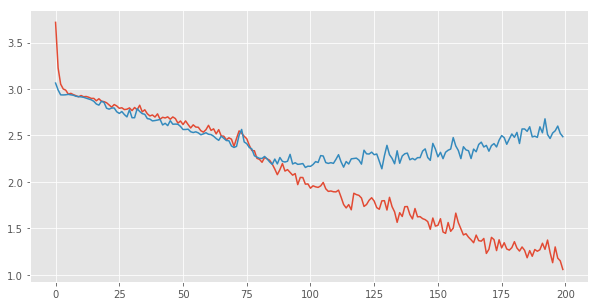

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

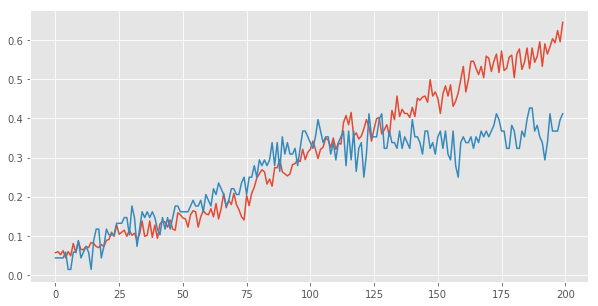

In [28]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.40707964601769914
Confusion matrix, without normalization
[[1 0 0 3 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [1 0 0 0 0 3 0 0 0 0 1 0 1 1 0 0 0 0 1]
 [0 0 1 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 4 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 2 0 0 1 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 3 1 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 1 0 0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 1 0 0 2 0 0 0 0]
 [0 1 3 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 0 2 0 0 1 0 2]
 [0 0 1 1 0 0 2 0 0 2 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 2]]


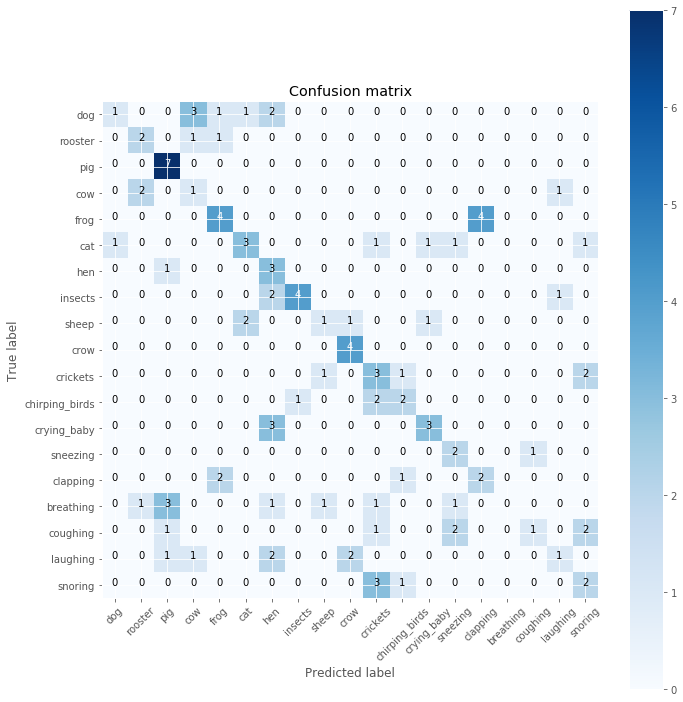

In [29]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [30]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [31]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [32]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 345, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 343, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 20, 16)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 19, 32)         5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 608)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               77952     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

640/640 [==============================] - 6s 9ms/step - loss: 2.9149 - acc: 0.0922 - mean_absolute_error: 0.0605 - val_loss: 3.0536 - val_acc: 0.0531 - val_mean_absolute_error: 0.0608
Epoch 32/200
640/640 [==============================] - 6s 9ms/step - loss: 2.9213 - acc: 0.1031 - mean_absolute_error: 0.0604 - val_loss: 2.9963 - val_acc: 0.0619 - val_mean_absolute_error: 0.0607
Epoch 33/200
640/640 [==============================] - 6s 9ms/step - loss: 2.9075 - acc: 0.1047 - mean_absolute_error: 0.0604 - val_loss: 3.0203 - val_acc: 0.0354 - val_mean_absolute_error: 0.0607
Epoch 34/200
640/640 [==============================] - 6s 9ms/step - loss: 2.8902 - acc: 0.0922 - mean_absolute_error: 0.0603 - val_loss: 2.9430 - val_acc: 0.0442 - val_mean_absolute_error: 0.0605
Epoch 35/200
640/640 [==============================] - 6s 9ms/step - loss: 2.9207 - acc: 0.1031 - mean_absolute_error: 0.0604 - val_loss: 2.9645 - val_acc: 0.0619 - val_mean_absolute_error: 0.0605
Epoch 36/200
640/640 [=

640/640 [==============================] - 5s 8ms/step - loss: 2.3597 - acc: 0.2563 - mean_absolute_error: 0.0551 - val_loss: 2.3620 - val_acc: 0.1858 - val_mean_absolute_error: 0.0548
Epoch 73/200
640/640 [==============================] - 5s 8ms/step - loss: 2.1753 - acc: 0.2859 - mean_absolute_error: 0.0536 - val_loss: 2.3876 - val_acc: 0.1770 - val_mean_absolute_error: 0.0548
Epoch 74/200
640/640 [==============================] - 5s 8ms/step - loss: 2.2359 - acc: 0.2609 - mean_absolute_error: 0.0538 - val_loss: 2.3875 - val_acc: 0.2035 - val_mean_absolute_error: 0.0545
Epoch 75/200
640/640 [==============================] - 5s 8ms/step - loss: 2.2845 - acc: 0.2719 - mean_absolute_error: 0.0536 - val_loss: 2.3723 - val_acc: 0.2212 - val_mean_absolute_error: 0.0543
Epoch 76/200
640/640 [==============================] - 6s 9ms/step - loss: 2.2798 - acc: 0.2766 - mean_absolute_error: 0.0539 - val_loss: 2.4170 - val_acc: 0.2301 - val_mean_absolute_error: 0.0547
Epoch 77/200
640/640 [=

640/640 [==============================] - 5s 8ms/step - loss: 1.6507 - acc: 0.4391 - mean_absolute_error: 0.0459 - val_loss: 2.1984 - val_acc: 0.2566 - val_mean_absolute_error: 0.0500
Epoch 114/200
640/640 [==============================] - 5s 8ms/step - loss: 1.7221 - acc: 0.4047 - mean_absolute_error: 0.0458 - val_loss: 2.1767 - val_acc: 0.2832 - val_mean_absolute_error: 0.0497
Epoch 115/200
640/640 [==============================] - 5s 8ms/step - loss: 1.6438 - acc: 0.4266 - mean_absolute_error: 0.0456 - val_loss: 2.1759 - val_acc: 0.2832 - val_mean_absolute_error: 0.0499
Epoch 116/200
640/640 [==============================] - 5s 9ms/step - loss: 1.6006 - acc: 0.4359 - mean_absolute_error: 0.0446 - val_loss: 2.1954 - val_acc: 0.3097 - val_mean_absolute_error: 0.0493
Epoch 117/200
640/640 [==============================] - 5s 8ms/step - loss: 1.5966 - acc: 0.4391 - mean_absolute_error: 0.0439 - val_loss: 2.2684 - val_acc: 0.2743 - val_mean_absolute_error: 0.0492
Epoch 118/200
640/6

640/640 [==============================] - 5s 9ms/step - loss: 1.3584 - acc: 0.5250 - mean_absolute_error: 0.0390 - val_loss: 2.3580 - val_acc: 0.3451 - val_mean_absolute_error: 0.0462
Epoch 155/200
640/640 [==============================] - 5s 8ms/step - loss: 1.2506 - acc: 0.5766 - mean_absolute_error: 0.0377 - val_loss: 2.2198 - val_acc: 0.3540 - val_mean_absolute_error: 0.0463
Epoch 156/200
640/640 [==============================] - 5s 8ms/step - loss: 1.2726 - acc: 0.5438 - mean_absolute_error: 0.0381 - val_loss: 2.2274 - val_acc: 0.3628 - val_mean_absolute_error: 0.0458
Epoch 157/200
640/640 [==============================] - 5s 9ms/step - loss: 1.2973 - acc: 0.5250 - mean_absolute_error: 0.0381 - val_loss: 2.2963 - val_acc: 0.3540 - val_mean_absolute_error: 0.0455
Epoch 158/200
640/640 [==============================] - 5s 8ms/step - loss: 1.2481 - acc: 0.5406 - mean_absolute_error: 0.0377 - val_loss: 2.4037 - val_acc: 0.3363 - val_mean_absolute_error: 0.0457
Epoch 159/200
640/6

640/640 [==============================] - 5s 8ms/step - loss: 0.9618 - acc: 0.6578 - mean_absolute_error: 0.0300 - val_loss: 2.5101 - val_acc: 0.3805 - val_mean_absolute_error: 0.0434
Epoch 196/200
640/640 [==============================] - 5s 9ms/step - loss: 1.0093 - acc: 0.6375 - mean_absolute_error: 0.0314 - val_loss: 2.5247 - val_acc: 0.3894 - val_mean_absolute_error: 0.0428
Epoch 197/200
640/640 [==============================] - 5s 8ms/step - loss: 0.9656 - acc: 0.6484 - mean_absolute_error: 0.0303 - val_loss: 2.5385 - val_acc: 0.3982 - val_mean_absolute_error: 0.0436
Epoch 198/200
640/640 [==============================] - 5s 8ms/step - loss: 1.0631 - acc: 0.6219 - mean_absolute_error: 0.0321 - val_loss: 2.4492 - val_acc: 0.3717 - val_mean_absolute_error: 0.0445
Epoch 199/200
640/640 [==============================] - 5s 8ms/step - loss: 1.0146 - acc: 0.6359 - mean_absolute_error: 0.0308 - val_loss: 2.7806 - val_acc: 0.3009 - val_mean_absolute_error: 0.0446
Epoch 200/200
640/6

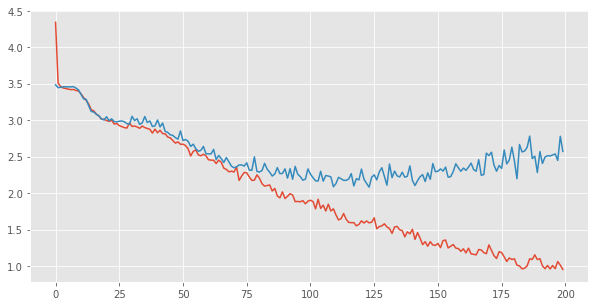

In [33]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

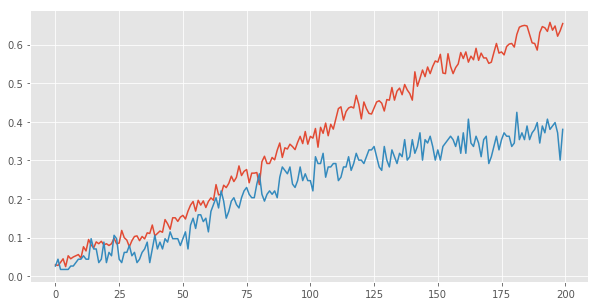

In [34]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.3492063492063492
Confusion matrix, without normalization
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 3 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 3 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 1 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 1 0 0 0 0 0 0 2 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 4 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 1 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 3 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1

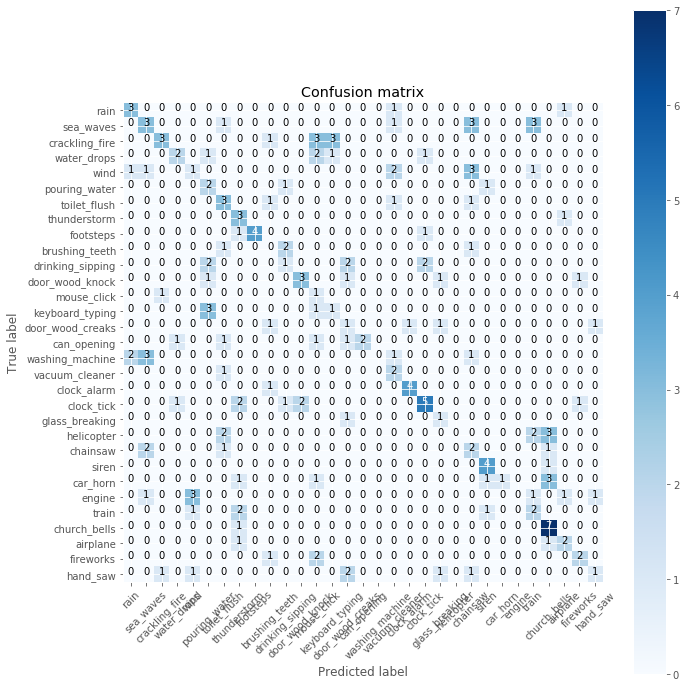

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 1.0751242637634277
	Processing Time: 1.1897001266479492
	Processing Time: 1.0200018882751465
	Processing Time: 1.0222394466400146


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(6058, 1, 88200)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(6058,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(6058,)


0.7355562892043579
Confusion matrix, without normalization
[[1218 1060]
 [ 542 3238]]


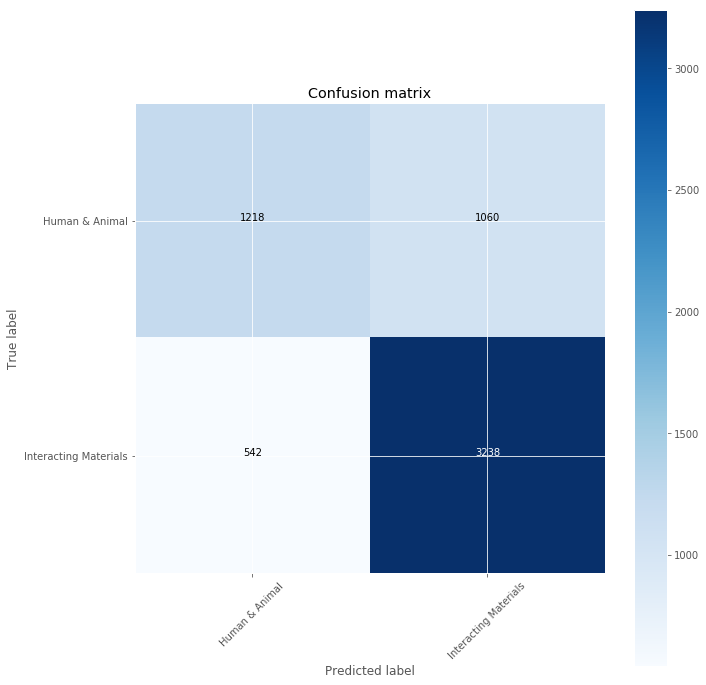

In [40]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [41]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.28314310798946446
Confusion matrix, without normalization
[[20  4  2 14  2  5 29  7  3 10  0  0 10  8  3  1  0  2  0]
 [ 4 40  3 11  0  1  8  2  4 13  1  1  4 14  0  1  3  1  4]
 [ 0  3 32  3  5  0 18  3  0  8  2  7  0  0 28  1  2  1  1]
 [ 1 13  4 22  0  4 38  8  4  1  1  2 13  1  1  0  0  2  4]
 [ 6  0  1 10 31  0  0  5 10  9  1 12  3  2 38  0  0  0  0]
 [18 13  1 12  0 22  5  8  7  3  1  2  6  4  0  0  1  2  7]
 [ 6  2 14  8  0 13 45  4  0  1  0  1 22  1  0  0  1  2  3]
 [ 4  2  8  1  0 23  8 21  7  4  5  9  4  4  7  0  1  1 16]
 [ 1  1  0  6  0  8  1 21 36 34  1  4  7  1  4  0  0  1  2]
 [ 3  4  1 14  6  4  2  8 19 53  1  0  0  0  3  0  0  3  0]
 [ 7  0  4  0  2  1  1  2  0  8 16 61  0  4  1  0  0  0 21]
 [ 1  0 11  2  1  0  5  1  3  0 23 65  1  1  2  0  0  0 12]
 [ 2  1  6  3  4 13 11  3  7 10  0  2 51  1  3  2  0  6  2]
 [ 2  2  2  1  3  1  0  4  5  8  6  7  1 42  1  2  7  4  5]
 [ 0  0  4  0 13  0  0  0  0 13  0  5  0  5 84  0  1  0  1]
 [ 2  6  3 11  1  6 10 10 22 11  4  4  2

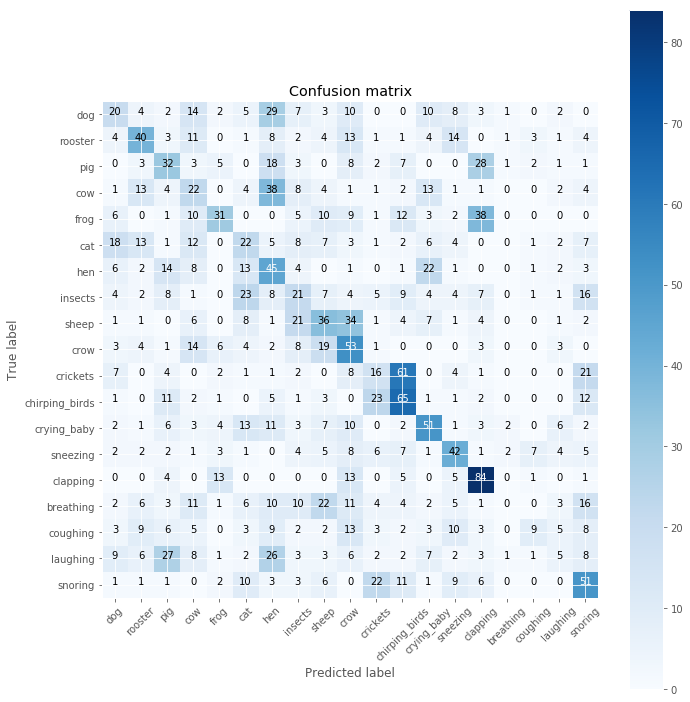

In [42]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.18941798941798943
Confusion matrix, without normalization
[[45  7  1  0  2  0 15  0  0  1  0  0  0  0  0  0  3 26  0  0  0  6  8  0
   0  0  0  2 10  0  2]
 [ 0 25  0  0  1  0 37  0  0  2  0  0  0  0  1  0  1  9  0  0  1  0 34  0
   0  5  8  3  1  0  0]
 [ 0  0 21  0  4 19  3  0  5 10  5  0 14 34  0  1  0  2  0  3  2  2  0  0
   0  0  0  0  0  0  2]
 [ 0  0  3 10  1  9  1  5  7  0 13  2 14 11  4  3  0  0  1 11 10  0  0  0
   0  1  0  0  2  5  0]
 [ 0  4  0  0 25  0  0 10  0  0  0  0  0  0  0  0  1  0  0  0  0  1  3 19
   0  1 26 24 11  3  0]
 [ 0  0  2  2  0 43  1  0  1  4  1  7  3  7  5  2  0  0 14  0  9  0  0 12
   1  1  0  2  0  0  9]
 [ 8  6  0  0  7  0 33  1  0 10  2  1  0  0  3  0  1 15  2  0  0  2 10  3
   1  1  0  1 12  3  6]
 [ 0  0  0  0  9  0  0 51  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0 20
   0  5  2 17 19  1  1]
 [ 2  4  1  1  9 10  1  8 11 14  4  7  0  0  2  0  1  1  0  1  0  1  0  3
   5  9  1  6  1  8 15]
 [ 1  3  8  0 18  4  4  0  2 15  0  0  4  1  3  0  0  2  4

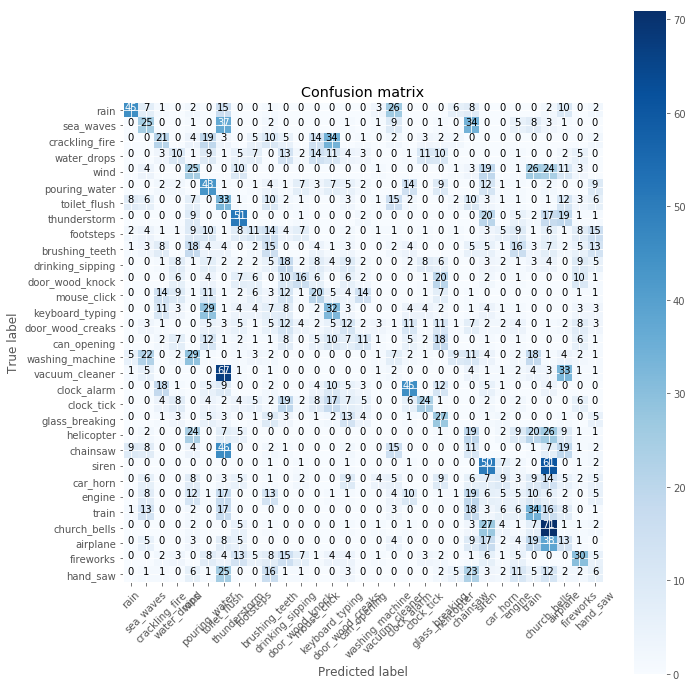

In [43]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

In [44]:
clas.predict_proba(X)

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.02013505, 0.97986495],
       ...,
       [0.0017947 , 0.9982053 ],
       [0.7920797 , 0.20792034],
       [0.3897679 , 0.6102321 ]], dtype=float32)

# Testing Accuracy of Single File

In [45]:
data_iloc = 1

In [46]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_category)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [47]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.008722543716430664


In [48]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

4/4 [==============================] - 0s 7ms/step


In [49]:
np.average(pred_prob, axis=0)

array([0.54775196, 0.45224804], dtype=float32)

In [50]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

4/4 [==============================] - 0s 4ms/step


In [51]:
np.average(pred_prob, axis=0)

array([1.00505149e-05, 5.37056709e-04, 3.10856313e-01, 5.81210200e-03,
       1.07163064e-01, 9.15344572e-05, 5.28011005e-03, 4.16984744e-02,
       7.84486256e-05, 5.94252255e-03, 6.16282523e-06, 2.60960497e-03,
       2.64027884e-04, 6.06833864e-03, 4.29535985e-01, 5.96582182e-02,
       1.81671083e-02, 6.21624431e-03, 4.68430335e-06], dtype=float32)

In [52]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

22


In [53]:
print(dataset.iloc[data_iloc])

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


In [54]:
predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    top_pred_probs.append(clas.predict_proba(x_file))
    prob = np.average(top_pred_probs[-1], axis=0)
    if prob[0] > 0.5:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(anim.predict_proba(x_file))
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(inter.predict_proba(x_file))
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.0023660659790039062
	Processing Time: 0.0019376277923583984
	Processing Time: 0.004512310028076172
	Processing Time: 0.0020904541015625
	Processing Time: 0.0023844242095947266
	Processing Time: 0.002014636993408203
	Processing Time: 0.002136707305908203
	Processing Time: 0.001980304718017578
	Processing Time: 0.002184152603149414
	Processing Time: 0.0019638538360595703
	Processing Time: 0.002048492431640625
	Processing Time: 0.0023093223571777344
	Processing Time: 0.002093076705932617
	Processing Time: 0.002240419387817383
	Processing Time: 0.002003192901611328
	Processing Time: 0.002445697784423828
	Processing Time: 0.002030611038208008
	Processing Time: 0.002465963363647461
	Processing Time: 0.0023772716522216797
	Processing Time: 0.003314495086669922
	Processing Time: 0.003711700439453125
	Processing Time: 0.003214597702026367
	Processing Time: 0.004552125930786133
	Processing Time: 0.003561735153198242
	Processing Time: 0.002655506134033203
	Processing Time: 0.0

	Processing Time: 0.002064943313598633
	Processing Time: 0.00180816650390625
	Processing Time: 0.0021407604217529297
	Processing Time: 0.002988100051879883
	Processing Time: 0.0016813278198242188
	Processing Time: 0.0025196075439453125
	Processing Time: 0.0021500587463378906
	Processing Time: 0.0018396377563476562
	Processing Time: 0.0025272369384765625
	Processing Time: 0.002226114273071289
	Processing Time: 0.0022630691528320312
	Processing Time: 0.0024347305297851562
	Processing Time: 0.0024394989013671875
	Processing Time: 0.0020456314086914062
	Processing Time: 0.002363443374633789
	Processing Time: 0.002022266387939453
	Processing Time: 0.002201557159423828
	Processing Time: 0.001955270767211914
	Processing Time: 0.002071380615234375
	Processing Time: 0.0023889541625976562
	Processing Time: 0.002195119857788086
	Processing Time: 0.0020842552185058594
	Processing Time: 0.0020325183868408203
	Processing Time: 0.002351999282836914
	Processing Time: 0.0018534660339355469
	Processing 

	Processing Time: 0.0023717880249023438
	Processing Time: 0.002227783203125
	Processing Time: 0.002214193344116211
	Processing Time: 0.002117156982421875
	Processing Time: 0.00174713134765625
	Processing Time: 0.0026133060455322266
	Processing Time: 0.0018315315246582031
	Processing Time: 0.002126455307006836
	Processing Time: 0.002119779586791992
	Processing Time: 0.002053976058959961
	Processing Time: 0.0019047260284423828
	Processing Time: 0.0023310184478759766
	Processing Time: 0.0017650127410888672
	Processing Time: 0.001963376998901367
	Processing Time: 0.003029346466064453
	Processing Time: 0.0020570755004882812
	Processing Time: 0.0020835399627685547
	Processing Time: 0.002012491226196289
	Processing Time: 0.001863718032836914
	Processing Time: 0.0020189285278320312
	Processing Time: 0.002239704132080078
	Processing Time: 0.0020465850830078125
	Processing Time: 0.0018515586853027344
	Processing Time: 0.0031006336212158203
	Processing Time: 0.0029757022857666016
	Processing Time

	Processing Time: 0.002795696258544922
	Processing Time: 0.0020885467529296875
	Processing Time: 0.0022513866424560547
	Processing Time: 0.0026030540466308594
	Processing Time: 0.0020253658294677734
	Processing Time: 0.002429485321044922
	Processing Time: 0.0020220279693603516
	Processing Time: 0.0022323131561279297
	Processing Time: 0.0020122528076171875
	Processing Time: 0.0022628307342529297
	Processing Time: 0.002407550811767578
	Processing Time: 0.002351522445678711
	Processing Time: 0.001796722412109375
	Processing Time: 0.002090930938720703
	Processing Time: 0.0019598007202148438
	Processing Time: 0.0022666454315185547
	Processing Time: 0.0017960071563720703
	Processing Time: 0.0022668838500976562
	Processing Time: 0.0023598670959472656
	Processing Time: 0.002340078353881836
	Processing Time: 0.0022339820861816406
	Processing Time: 0.0020780563354492188
	Processing Time: 0.0017616748809814453
	Processing Time: 0.0023751258850097656
	Processing Time: 0.002104520797729492
	Process

	Processing Time: 0.0018229484558105469
	Processing Time: 0.0022590160369873047
	Processing Time: 0.0018494129180908203
	Processing Time: 0.001995563507080078
	Processing Time: 0.001920461654663086
	Processing Time: 0.002099275588989258
	Processing Time: 0.0018775463104248047
	Processing Time: 0.002014636993408203
	Processing Time: 0.003074169158935547
	Processing Time: 0.0020503997802734375
	Processing Time: 0.002635955810546875
	Processing Time: 0.0018336772918701172
	Processing Time: 0.0023636817932128906
	Processing Time: 0.001837015151977539
	Processing Time: 0.0019617080688476562
	Processing Time: 0.0018303394317626953
	Processing Time: 0.0019986629486083984
	Processing Time: 0.0028297901153564453
	Processing Time: 0.0023751258850097656
	Processing Time: 0.002418994903564453
	Processing Time: 0.0021352767944335938
	Processing Time: 0.0019860267639160156
	Processing Time: 0.002186298370361328
	Processing Time: 0.002251863479614258
	Processing Time: 0.0023555755615234375
	Processin

	Processing Time: 0.0019626617431640625
	Processing Time: 0.0018715858459472656
	Processing Time: 0.0028221607208251953
	Processing Time: 0.003485441207885742
	Processing Time: 0.0020389556884765625
	Processing Time: 0.002295255661010742
	Processing Time: 0.0017156600952148438
	Processing Time: 0.0019829273223876953
	Processing Time: 0.001787424087524414
	Processing Time: 0.0019593238830566406
	Processing Time: 0.002186298370361328
	Processing Time: 0.002033233642578125
	Processing Time: 0.0021042823791503906
	Processing Time: 0.0020003318786621094
	Processing Time: 0.0017609596252441406
	Processing Time: 0.002035379409790039
	Processing Time: 0.0020318031311035156
	Processing Time: 0.0032432079315185547
	Processing Time: 0.002300262451171875
	Processing Time: 0.0030243396759033203
	Processing Time: 0.0029451847076416016
	Processing Time: 0.002725839614868164
	Processing Time: 0.0033142566680908203
	Processing Time: 0.0024900436401367188
	Processing Time: 0.002822399139404297
	Processi

	Processing Time: 0.0019910335540771484
	Processing Time: 0.002176046371459961
	Processing Time: 0.002395153045654297
	Processing Time: 0.002131938934326172
	Processing Time: 0.0024871826171875
	Processing Time: 0.0021164417266845703
	Processing Time: 0.002525806427001953
	Processing Time: 0.0022077560424804688
	Processing Time: 0.002243518829345703
	Processing Time: 0.002099752426147461
	Processing Time: 0.002229928970336914
	Processing Time: 0.001956939697265625
	Processing Time: 0.0027017593383789062
	Processing Time: 0.0020945072174072266
	Processing Time: 0.0021097660064697266
	Processing Time: 0.0018546581268310547
	Processing Time: 0.0019834041595458984
	Processing Time: 0.0018167495727539062
	Processing Time: 0.0026481151580810547
	Processing Time: 0.00220489501953125
	Processing Time: 0.002094745635986328
	Processing Time: 0.0019123554229736328
	Processing Time: 0.0016689300537109375
	Processing Time: 0.001971006393432617
	Processing Time: 0.0021703243255615234
	Processing Tim

	Processing Time: 0.002450227737426758
	Processing Time: 0.002115964889526367
	Processing Time: 0.0020492076873779297
	Processing Time: 0.002763986587524414
	Processing Time: 0.002071857452392578
	Processing Time: 0.002483844757080078
	Processing Time: 0.0025670528411865234
	Processing Time: 0.0025641918182373047
	Processing Time: 0.002233743667602539
	Processing Time: 0.0022361278533935547
	Processing Time: 0.0022635459899902344
	Processing Time: 0.0021800994873046875
	Processing Time: 0.002245187759399414
	Processing Time: 0.0020225048065185547
	Processing Time: 0.002027750015258789
	Processing Time: 0.002374410629272461
	Processing Time: 0.002182483673095703
	Processing Time: 0.002245187759399414
	Processing Time: 0.001994609832763672
	Processing Time: 0.002414703369140625
	Processing Time: 0.0022842884063720703
	Processing Time: 0.002008199691772461
	Processing Time: 0.001932382583618164
	Processing Time: 0.002153635025024414
	Processing Time: 0.0021429061889648438
	Processing Time

	Processing Time: 0.0023255348205566406
	Processing Time: 0.0021424293518066406
	Processing Time: 0.002314329147338867
	Processing Time: 0.0018112659454345703
	Processing Time: 0.002068758010864258
	Processing Time: 0.002079010009765625
	Processing Time: 0.003531932830810547
	Processing Time: 0.0028917789459228516
	Processing Time: 0.002797842025756836
	Processing Time: 0.0038034915924072266
	Processing Time: 0.003298521041870117
	Processing Time: 0.002832174301147461
	Processing Time: 0.0025072097778320312
	Processing Time: 0.0033092498779296875
	Processing Time: 0.0023288726806640625
	Processing Time: 0.0023305416107177734
	Processing Time: 0.003895998001098633
	Processing Time: 0.0025076866149902344
	Processing Time: 0.002232074737548828
	Processing Time: 0.0024900436401367188
	Processing Time: 0.0024955272674560547
	Processing Time: 0.0021576881408691406
	Processing Time: 0.0028476715087890625
	Processing Time: 0.002270936965942383
	Processing Time: 0.002309560775756836
	Processing

	Processing Time: 0.0022706985473632812
	Processing Time: 0.002288818359375
	Processing Time: 0.0019397735595703125
	Processing Time: 0.0019867420196533203
	Processing Time: 0.0019888877868652344
	Processing Time: 0.0016553401947021484
	Processing Time: 0.0018010139465332031
	Processing Time: 0.001825571060180664
	Processing Time: 0.002088308334350586
	Processing Time: 0.0020232200622558594
	Processing Time: 0.0017380714416503906
	Processing Time: 0.0017142295837402344
	Processing Time: 0.001903533935546875
	Processing Time: 0.0019674301147460938
	Processing Time: 0.0021283626556396484
	Processing Time: 0.0018491744995117188
	Processing Time: 0.0019583702087402344
	Processing Time: 0.0021331310272216797
	Processing Time: 0.0020422935485839844
	Processing Time: 0.0031778812408447266
	Processing Time: 0.0032494068145751953
	Processing Time: 0.002454042434692383
	Processing Time: 0.002588987350463867
	Processing Time: 0.002505064010620117
	Processing Time: 0.002420186996459961
	Processing

In [55]:
targs = np.vstack(full_targets)

0.143
Confusion matrix, without normalization
[[ 7  2  1 ...  0  0  1]
 [ 2 22  0 ...  0  1  0]
 [ 0  2 11 ...  0  0  2]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  2  4  4]
 [ 0  0  2 ...  0  0  4]]


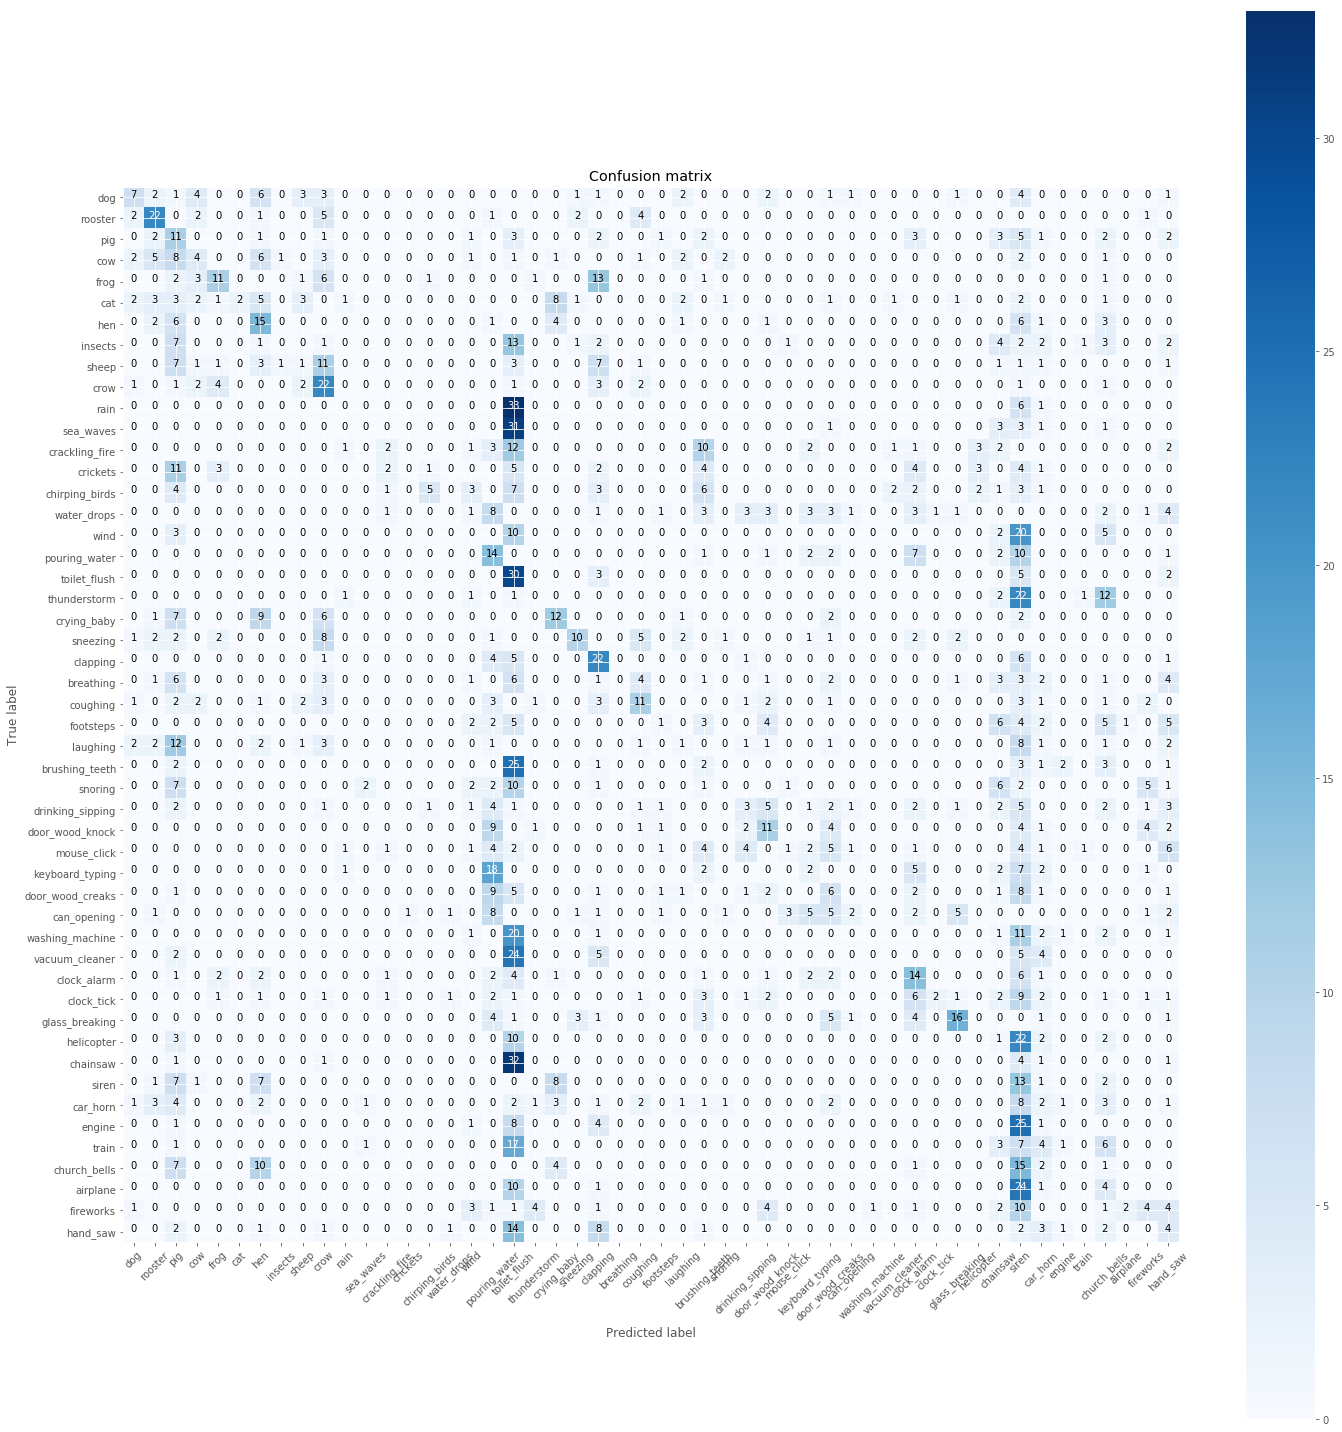

In [56]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

filename      1-100032-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                100032
take                         A
h_category                   0
Name: 0, dtype: object


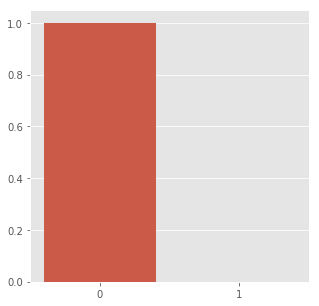

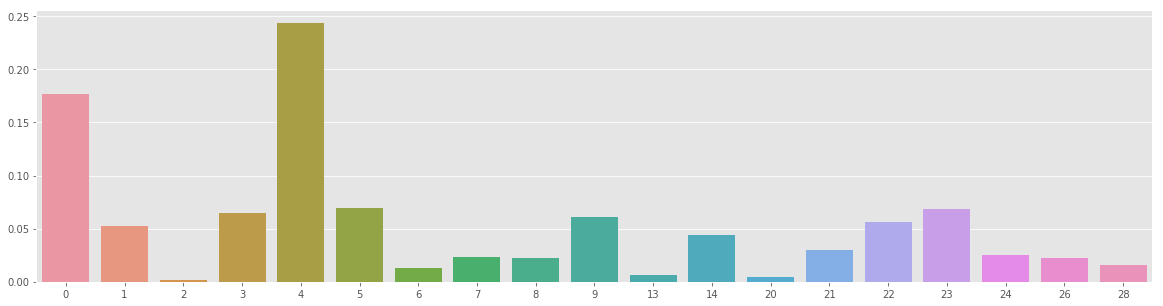

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


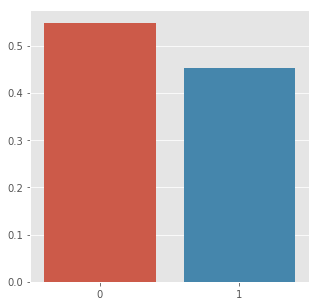

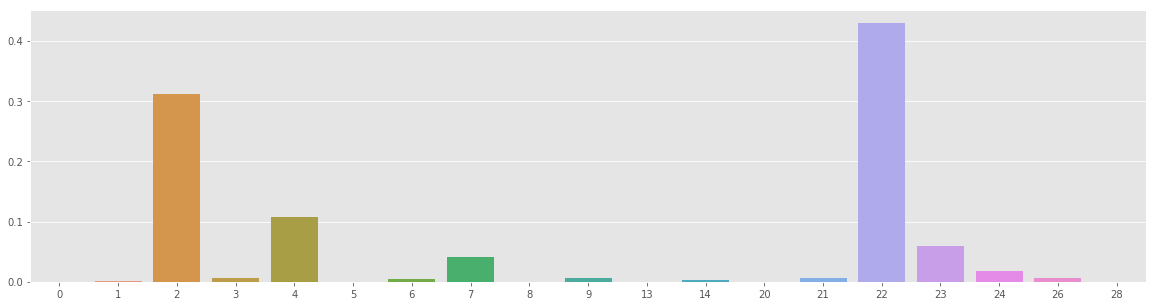

filename      1-100210-A-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          A
h_category                    1
Name: 2, dtype: object


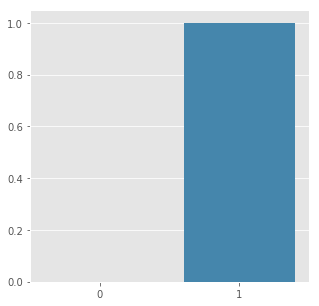

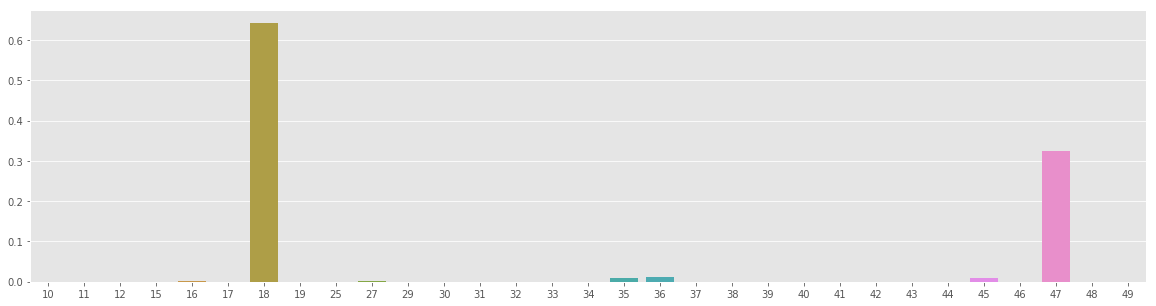

filename      1-100210-B-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          B
h_category                    1
Name: 3, dtype: object


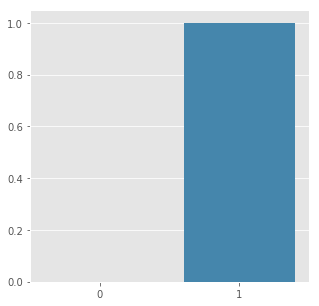

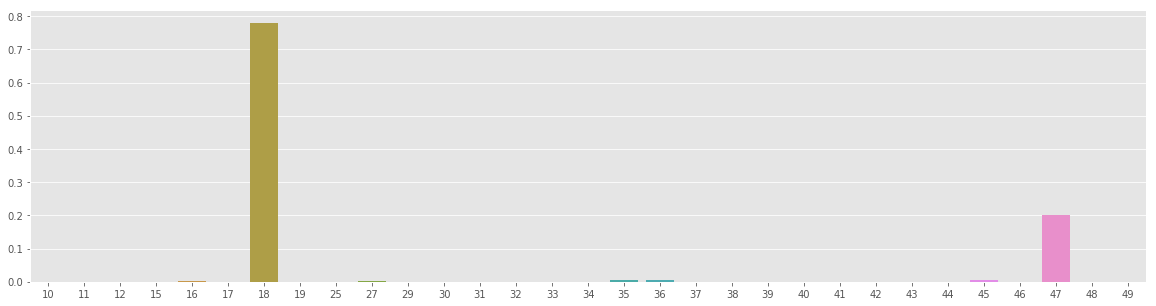

filename      1-101296-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          A
h_category                    1
Name: 4, dtype: object


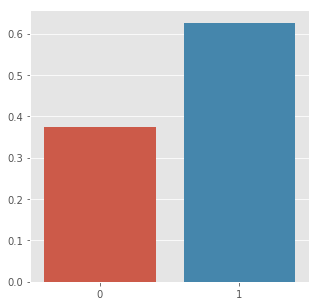

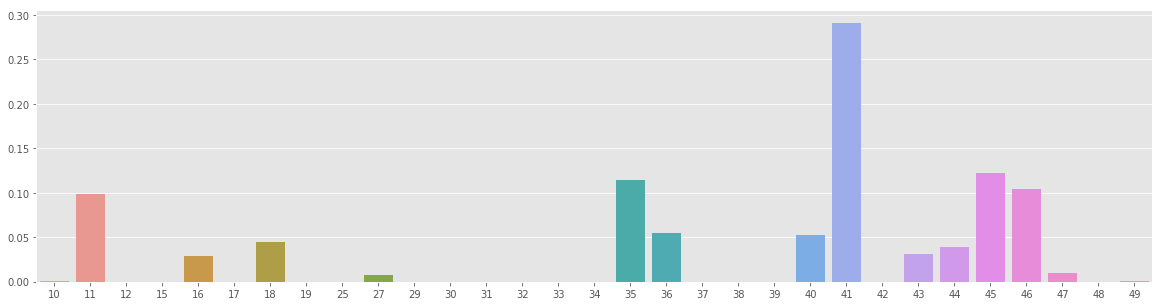

filename      1-101296-B-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          B
h_category                    1
Name: 5, dtype: object


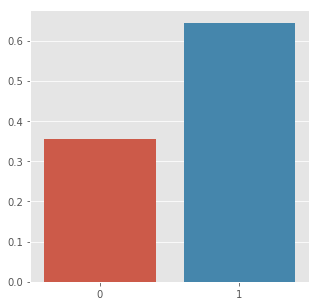

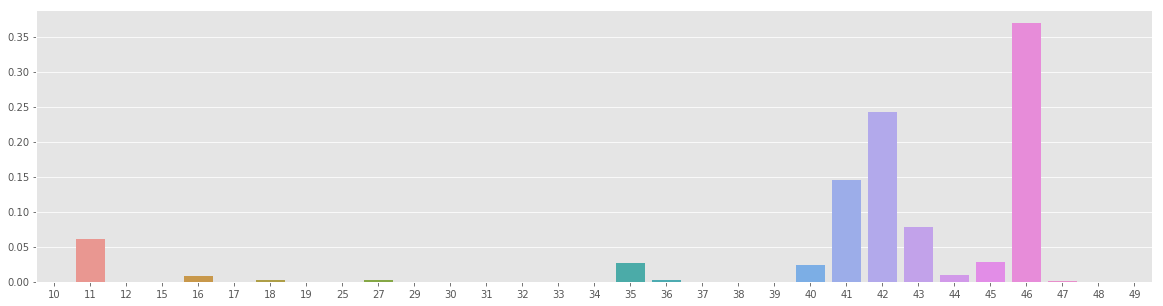

filename      1-101336-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 101336
take                          A
h_category                    1
Name: 6, dtype: object


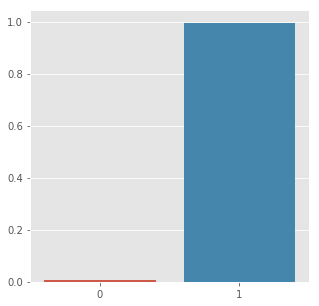

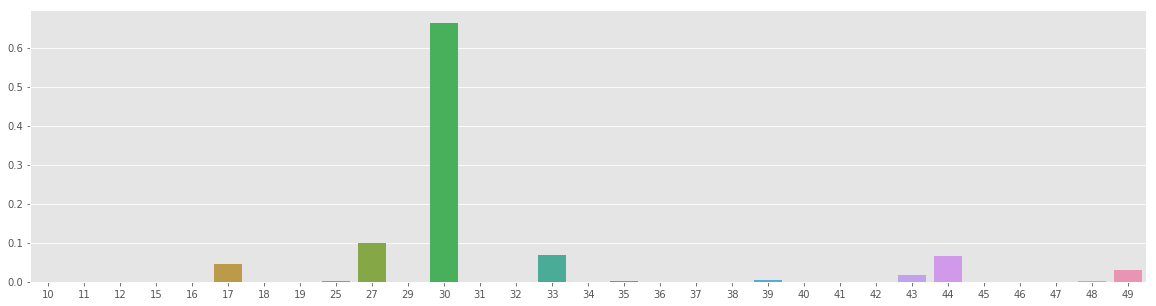

filename      1-101404-A-34.wav
fold                          1
target                       34
category            can_opening
esc10                     False
src_file                 101404
take                          A
h_category                    1
Name: 7, dtype: object


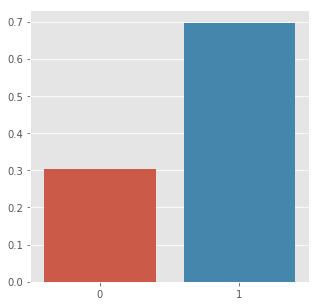

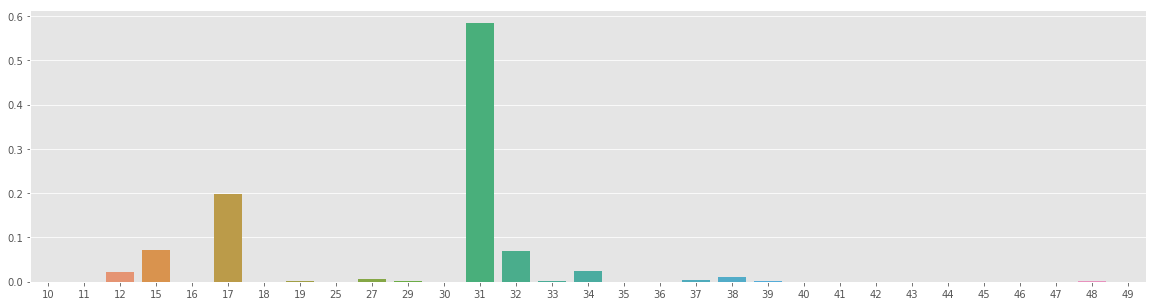

filename      1-103298-A-9.wav
fold                         1
target                       9
category                  crow
esc10                    False
src_file                103298
take                         A
h_category                   0
Name: 8, dtype: object


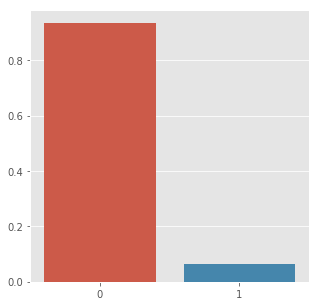

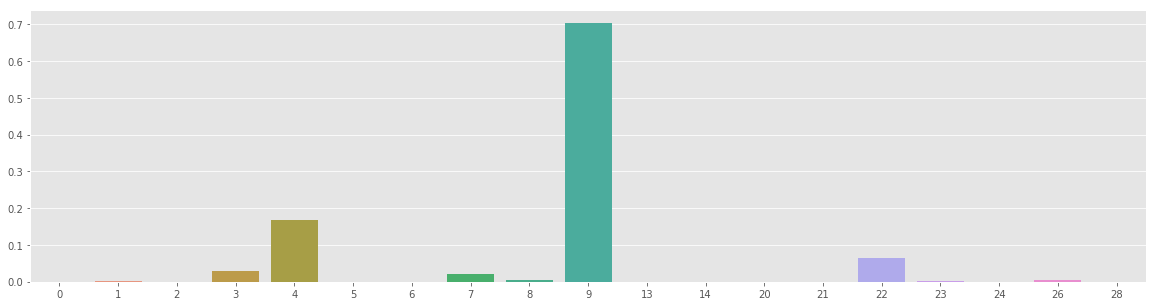

filename      1-103995-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103995
take                          A
h_category                    1
Name: 9, dtype: object


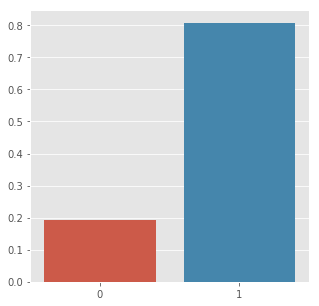

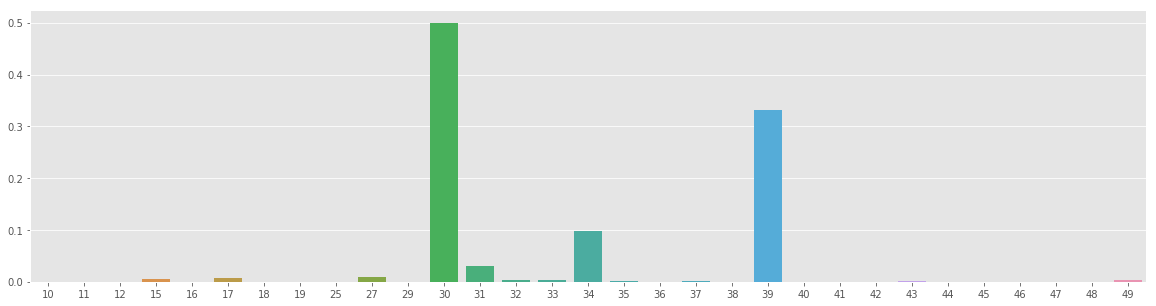

filename      1-103999-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103999
take                          A
h_category                    1
Name: 10, dtype: object


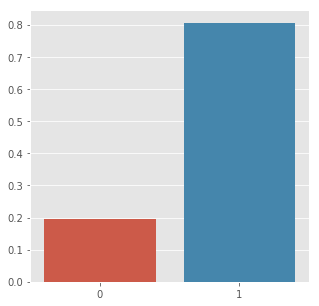

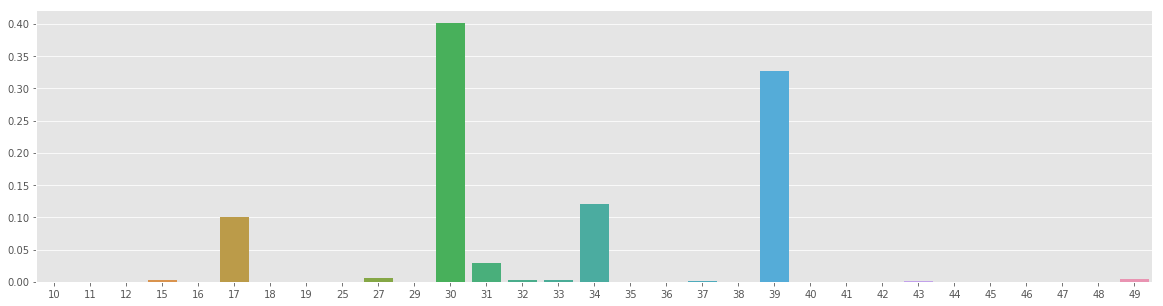

filename      1-104089-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          A
h_category                    0
Name: 11, dtype: object


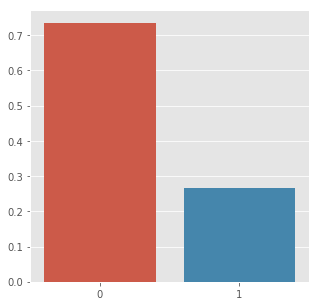

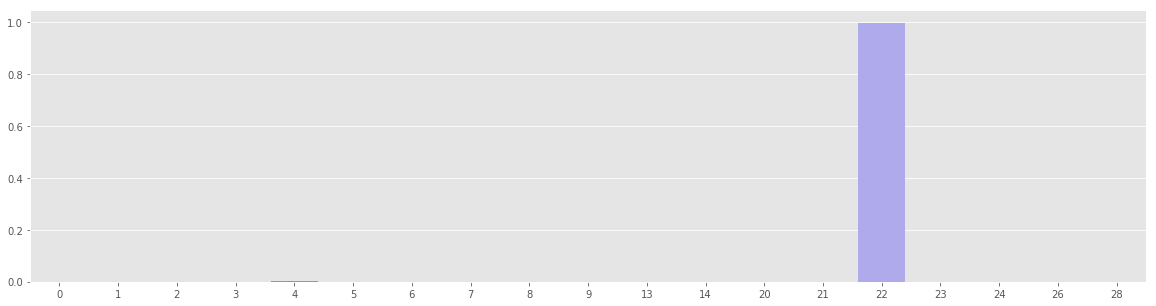

filename      1-104089-B-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          B
h_category                    0
Name: 12, dtype: object


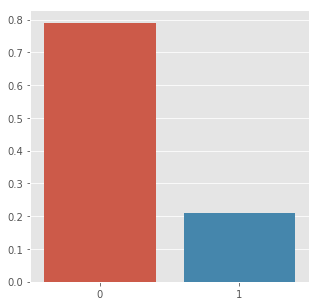

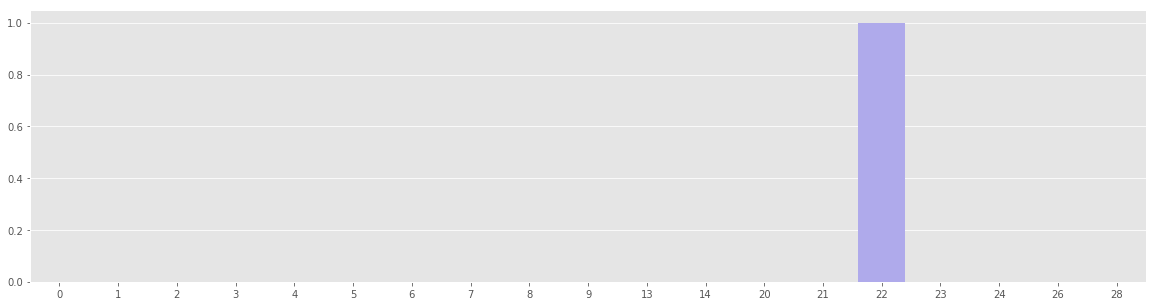

filename      1-105224-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 105224
take                          A
h_category                    0
Name: 13, dtype: object


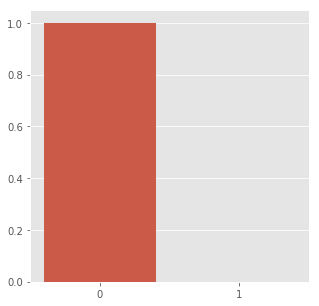

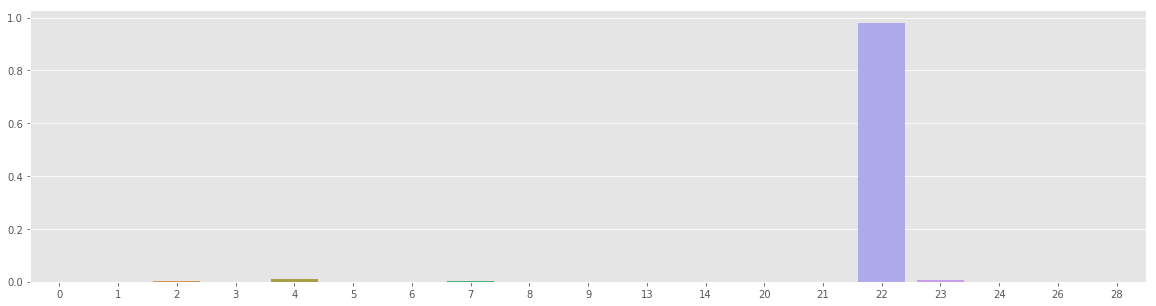

filename      1-110389-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                110389
take                         A
h_category                   0
Name: 14, dtype: object


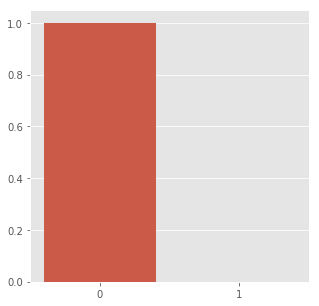

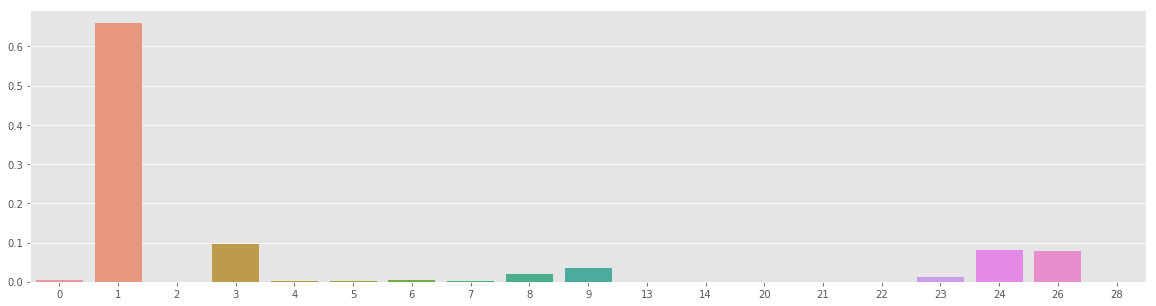

filename      1-110537-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 110537
take                          A
h_category                    0
Name: 15, dtype: object


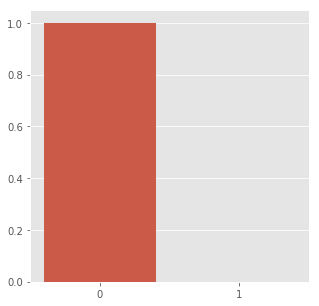

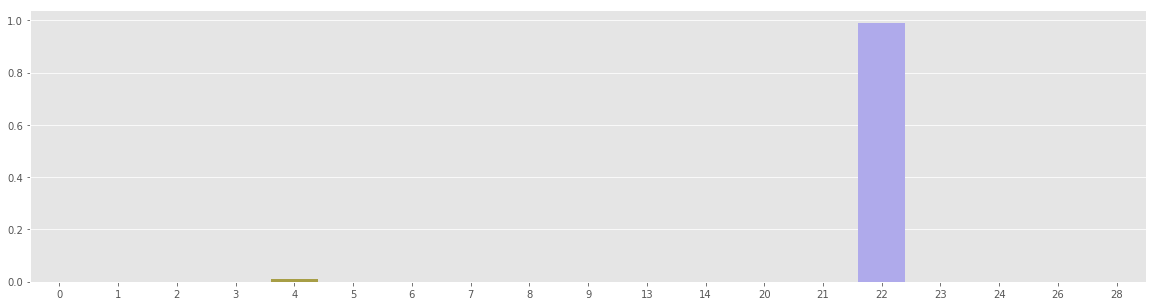

filename      1-115521-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 115521
take                          A
h_category                    1
Name: 16, dtype: object


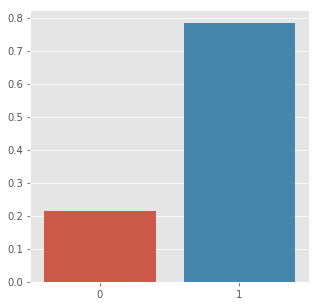

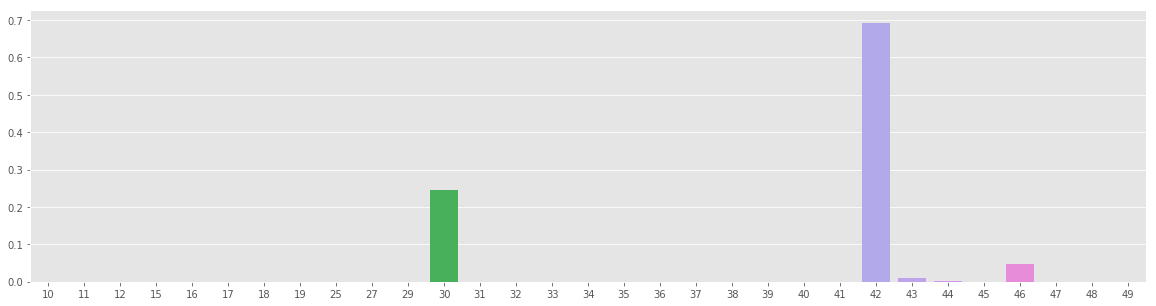

filename      1-115545-A-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          A
h_category                    1
Name: 17, dtype: object


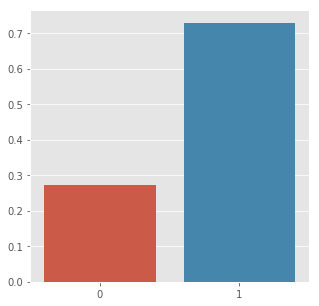

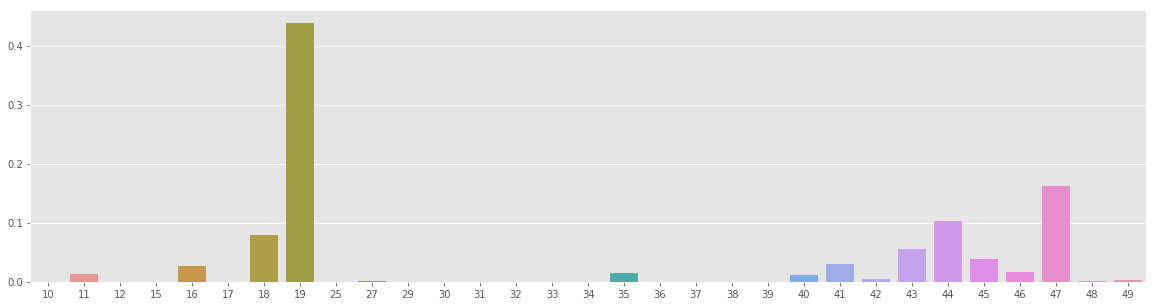

filename      1-115545-B-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          B
h_category                    1
Name: 18, dtype: object


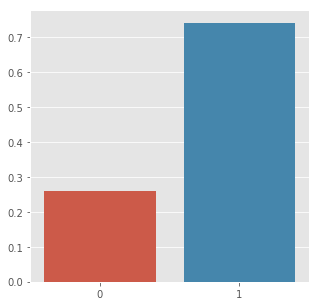

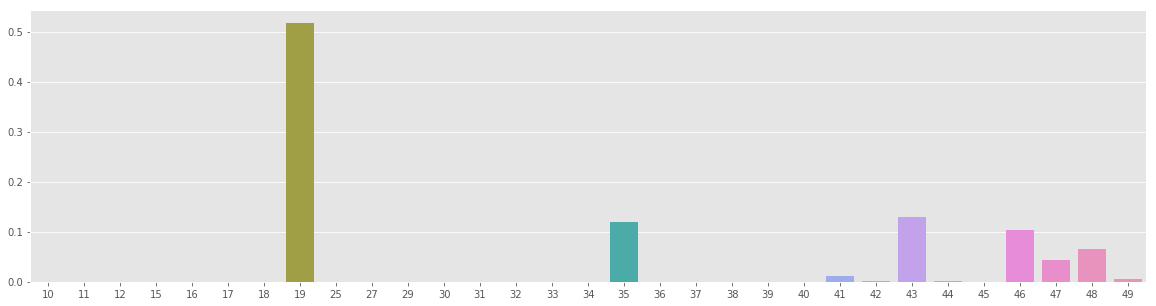

filename      1-115545-C-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          C
h_category                    1
Name: 19, dtype: object


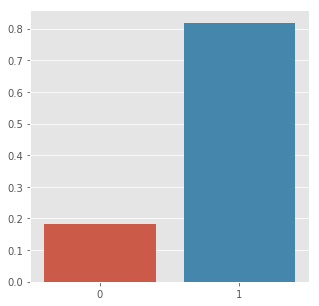

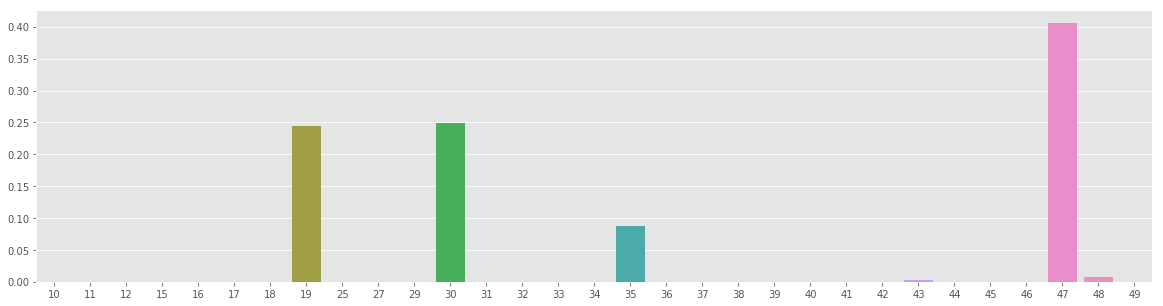

In [57]:
import seaborn as sns

for i in range(0,20):
    prob = pred_probs[i]
    print(dataset.iloc[i])

    xs = np.unique(targets)
    ys = np.average(top_pred_probs[i], axis=0)

    plt.figure(figsize=(5,5))
    sns.barplot(xs, ys)
    
    xs = np.unique(a_targ)
    ys = np.average(prob, axis=0)
    if(len(ys)!=len(xs)):
        xs = np.unique(i_targ)

    plt.figure(figsize=(20,5))
    sns.barplot(xs, ys)
    plt.show()